In [1]:
import numpy as np
import dedalus.public as d3
import logging
logger = logging.getLogger(__name__)
import copy
import h5py
import numpy as np
import matplotlib
import re

import matplotlib.pyplot as plt
from dedalus.extras import plot_tools

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import Normalize

import os
from os import listdir


# Parameters
Lx, Lz = 64,1
Nx, Nz = 8196,128
Ra_M = 4e5
D_0 = 0
D_H = 1/3
M_0 = 0
M_H = -1
N_s2=4/3
Qrad=0.0028

Prandtl = 1
dealias = 3/2
stop_sim_time = 1500
timestepper = d3.RK222
max_timestep = 0.125
dtype = np.float64

# %%
# Bases
coords = d3.CartesianCoordinates('x','z')
dist = d3.Distributor(coords, dtype=dtype)
xbasis = d3.RealFourier(coords['x'], size=Nx, bounds=(0, Lx), dealias=dealias)
zbasis = d3.ChebyshevT(coords['z'], size=Nz, bounds=(0, Lz), dealias=dealias)

# Fields
p = dist.Field(name='p', bases=(xbasis,zbasis))
D = dist.Field(name='D', bases=(xbasis,zbasis))
M = dist.Field(name='M', bases=(xbasis,zbasis))
u = dist.VectorField(coords, name='u', bases=(xbasis,zbasis))
Z = dist.Field(name='Z', bases=zbasis)
T = dist.Field(name='T', bases=(xbasis,zbasis))
C = dist.Field(name='C', bases=(xbasis,zbasis))

x,z = dist.local_grids(xbasis,zbasis)
Z['g']=z
Z.change_scales(3/2)

#list
RaMlist=[1e8]
D_Hlist=[0.33]
Qlist=[0.0014,0.0028,0.0042,0.0056,0.0070]
#list of dir with name RaM+D_H+'Q='+Q
save_dirlist=[]
plot_dirlist=[]
nu_list=[]

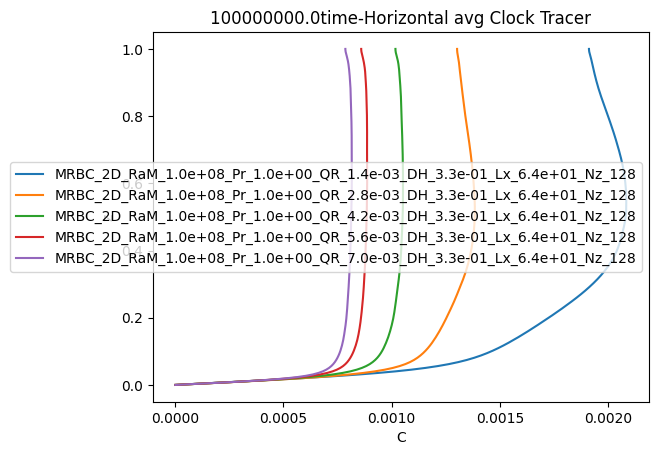

<Figure size 640x480 with 0 Axes>

In [3]:
for RaM in RaMlist:
    for QRAD in Qlist:
        save_dirlist.append("/scratch/zb2113/DedalusData/2D/"+'MRBC_2D_RaM_'+"{:.1e}".format(RaM)  +'_Pr_'+"{:.1e}".format(Prandtl) \
+'_QR_'+"{:.1e}".format(QRAD) \
        +'_DH_'+"{:.1e}".format(D_H) \
        +  '_Lx_'+"{:.1e}".format(Lx) \
        +   '_Nz_'+"{:d}".format(Nz))
        plot_dirlist.append("/home/zb2113/Dedalus-Postanalysis/2D/"+'MRBC_2D_RaM_'+"{:.1e}".format(RaM)  +'_Pr_'+"{:.1e}".format(Prandtl) \
+'_QR_'+"{:.1e}".format(QRAD) \
        +'_DH_'+"{:.1e}".format(D_H) \
        +  '_Lx_'+"{:.1e}".format(Lx) \
        +   '_Nz_'+"{:d}".format(Nz))
        nu = (Ra_M / (Prandtl*(M_0-M_H)*Lz**3))**(-1/2)
        # nu_list.append(nu)
        
        #test
        save_dir="/scratch/zb2113/DedalusData/2D/"+'MRBC_2D_RaM_'+"{:.1e}".format(RaM)  +'_Pr_'+"{:.1e}".format(Prandtl) \
+'_QR_'+"{:.1e}".format(QRAD) \
        +'_DH_'+"{:.1e}".format(D_H) \
        +  '_Lx_'+"{:.1e}".format(Lx) \
        +   '_Nz_'+"{:d}".format(Nz)
        # plot_dir="/home/zb2113/Dedalus-Postanalysis/2D/"+str(RaM)+str(D_H)+'Q='+str(Q)
        plot_dir="/home/zb2113/Dedalus-Postanalysis/2D/general"
        folder_dir = save_dir+"/snapshots"
    
        file_paths = [os.path.join(folder_dir, file) for file in listdir(folder_dir) if os.path.isfile(os.path.join(folder_dir, file)) and file.endswith('.h5')]
        #sort by the number in the file name
        file_paths.sort(key=lambda f: int(re.sub('\D', '', f)))
    
        # #plot the function of total KE
        # all_tot_ke = []
        # nu=nu_list[i]
        # for file in file_paths:
        #     with h5py.File(file, mode='r') as file:
        #         tot_ke = file['tasks']['total KE']
        #         st = file['scales/sim_time']
        #         simtime = np.array(st)
        #         for t in range(0, len(simtime)):
        #             all_tot_ke.append(np.sum(tot_ke[t]))
        # print(all_tot_ke[:10])
        # print(max(all_tot_ke))
    
        # print(len(all_tot_ke))
        # figure_x_axis = np.array([(x*nu/(1**2)) for x in range(1, len(all_tot_ke)+1)])
        # print(len(figure_x_axis))
        # #create label with RaM, D_H, Q
        # pltlabel = save_dir.split('/')[-1]
        # plt.plot(figure_x_axis, np.log(all_tot_ke), label=pltlabel)
        
        #Plot time-horizontal avg C
    
        barC=np.zeros(Nz)
        count=0
        for file in file_paths:
            with h5py.File(file, mode='r') as file:
                count=count+1
                simtime = np.array(file['scales/sim_time'])
                for t in range(0, len(simtime)):
                    avgC = file['tasks']['horizontal avg C'][t, 0, :]
                    avgC = np.array(avgC)
                    
                #averaging
                avgC = avgC/len(simtime)
                barC+=avgC
    
        barC = barC/count
        barC = barC*nu/(1**2) #Normalization
        z = z.reshape(-1)
        # Plot the horizontal avg C
        pltlabel = save_dir.split('/')[-1]
        plt.plot(barC, z, label=pltlabel)
    
        # maxC = max(barC)
        # plt.axvline(x=maxC, color='black', linestyle='--', label='max C')
    
        # # Find the z value corresponding to max C and add a horizontal line
        # maxC_index = np.argmax(barC)
        # z_maxC = z[maxC_index]
        # plt.axhline(y=z_maxC, color='green', linestyle='--', label='z at max C')
    
        # Annotate the max C and its corresponding z value
        # plt.text(maxC, 0, f'max C: {maxC:.2f}', horizontalalignment='right', verticalalignment='bottom')
        # plt.text(0, z_maxC, f'z: {z_maxC:.2f}', horizontalalignment='left', verticalalignment='bottom')
    
plt.xlabel('C')
plt.ylabel('z')
plt.title(str(RaM)+'time-Horizontal avg Clock Tracer')
plt.legend()
plt.savefig(plot_dir + '/'+ str(RaM)+'time-Horizontal avg C.png', dpi=200, bbox_inches='tight')
plt.show()
plt.clf()

# #plot
# for i in range(len(save_dirlist)):
#     save_dir=save_dirlist[i]
#     plot_dir=plot_dirlist[i]
#     nu=nu_list[i]
#     folder_dir = save_dir+"/snapshots"
    
#     file_paths = [os.path.join(folder_dir, file) for file in listdir(folder_dir) if os.path.isfile(os.path.join(folder_dir, file)) and file.endswith('.h5')]
#     #sort by the number in the file name
#     file_paths.sort(key=lambda f: int(re.sub('\D', '', f)))
    
#     # #plot the function of total KE
#     # all_tot_ke = []

#     # for file in file_paths:
#     #     with h5py.File(file, mode='r') as file:
#     #         tot_ke = file['tasks']['total KE']
#     #         st = file['scales/sim_time']
#     #         simtime = np.array(st)
#     #         for t in range(0, len(simtime)):
#     #             all_tot_ke.append(np.sum(tot_ke[t]))
#     # print(all_tot_ke[:10])
#     # print(max(all_tot_ke))

#     # print(len(all_tot_ke))
#     # figure_x_axis = np.array([(x*nu/(1**2)) for x in range(1, len(all_tot_ke)+1)])
#     # print(len(figure_x_axis))
#     # #create label with RaM, D_H, Q
#     # pltlabel = save_dir.split('/')[-1]
#     # plt.plot(figure_x_axis, np.log(all_tot_ke), label=pltlabel)
    
#     #Plot time-horizontal avg C

#     barC=np.zeros(Nz)
#     count=0
#     for file in file_paths:
#         with h5py.File(file, mode='r') as file:
#             count=count+1
#             simtime = np.array(file['scales/sim_time'])
#             for t in range(0, len(simtime)):
#                 avgC = file['tasks']['horizontal avg C'][t, 0, :]
#                 avgC = np.array(avgC)
                
#             #averaging
#             avgC = avgC/len(simtime)
#             barC+=avgC

#     barC = barC/count
#     barC = barC*nu/(1**2) #Normalization
#     z = z.reshape(-1)
#     # Plot the horizontal avg C
#     pltlabel = save_dir.split('/')[-1]
#     plt.plot(barC, z, color='blue', label='C')

#     # maxC = max(barC)
#     # plt.axvline(x=maxC, color='black', linestyle='--', label='max C')

#     # # Find the z value corresponding to max C and add a horizontal line
#     # maxC_index = np.argmax(barC)
#     # z_maxC = z[maxC_index]
#     # plt.axhline(y=z_maxC, color='green', linestyle='--', label='z at max C')

#     # Annotate the max C and its corresponding z value
#     # plt.text(maxC, 0, f'max C: {maxC:.2f}', horizontalalignment='right', verticalalignment='bottom')
#     # plt.text(0, z_maxC, f'z: {z_maxC:.2f}', horizontalalignment='left', verticalalignment='bottom')

# plt.xlabel('C')
# plt.ylabel('z')
# plt.title('time-Horizontal avg Clock Tracer')
# plt.legend()
# plt.savefig(plot_dir + '/time-Horizontal avg C.png', dpi=200, bbox_inches='tight')
# plt.show()
# plt.clf()
    
    
    
# # plt.legend()  
# # plt.xlabel('Normalized Time')
# # plt.ylabel('Total Kinetic Energy')
# # plt.title('Total Kinetic Energy vs normalized time')
# # plt.savefig(plot_dir+'/Total norm KE.png', dpi=200, bbox_inches='tight')
# # plt.show()
# # plt.clf()

In [ ]:
z_n=55
z = z.reshape(-1)[:z_n]
for RaM in RaMlist:
    for QRAD in Qlist:
        kappa = (RaM * Prandtl/((M_0-M_H)*Lz**3))**(-1/2)
        save_dirlist.append("/scratch/zb2113/DedalusData/2D/"+'MRBC_2D_RaM_'+"{:.1e}".format(RaM)  +'_Pr_'+"{:.1e}".format(Prandtl) \
+'_QR_'+"{:.1e}".format(QRAD) \
        +'_DH_'+"{:.1e}".format(D_H) \
        +  '_Lx_'+"{:.1e}".format(Lx) \
        +   '_Nz_'+"{:d}".format(Nz))
        plot_dirlist.append("/home/zb2113/Dedalus-Postanalysis/2D/"+'MRBC_2D_RaM_'+"{:.1e}".format(RaM)  +'_Pr_'+"{:.1e}".format(Prandtl) \
+'_QR_'+"{:.1e}".format(QRAD) \
        +'_DH_'+"{:.1e}".format(D_H) \
        +  '_Lx_'+"{:.1e}".format(Lx) \
        +   '_Nz_'+"{:d}".format(Nz))
        nu = (Ra_M / (Prandtl*(M_0-M_H)*Lz**3))**(-1/2)
        # nu_list.append(nu)
        
        #test
        save_dir="/scratch/zb2113/DedalusData/2D/"+'MRBC_2D_RaM_'+"{:.1e}".format(RaM)  +'_Pr_'+"{:.1e}".format(Prandtl) \
+'_QR_'+"{:.1e}".format(QRAD) \
        +'_DH_'+"{:.1e}".format(D_H) \
        +  '_Lx_'+"{:.1e}".format(Lx) \
        +   '_Nz_'+"{:d}".format(Nz)
        # plot_dir="/home/zb2113/Dedalus-Postanalysis/2D/"+str(RaM)+str(D_H)+'Q='+str(Q)
        plot_dir="/home/zb2113/Dedalus-Postanalysis/2D/general"
        folder_dir = save_dir+"/snapshots"
    
        file_paths = [os.path.join(folder_dir, file) for file in listdir(folder_dir) if os.path.isfile(os.path.join(folder_dir, file)) and file.endswith('.h5')]
        #sort by the number in the file name
        file_paths.sort(key=lambda f: int(re.sub('\D', '', f)))
        
        #Plot time-horizontal avg C
    
        # Cdiffulist=np.zeros(Nz)
        # CReynoldslist=np.zeros(Nz)
        Kaeddybar=np.zeros(z_n)
        count=0
        for file in file_paths:
            with h5py.File(file, mode='r') as file:
                count=count+1
                simtime = np.array(file['scales/sim_time'])
                for t in range(0, len(simtime)):
                    Cdiffu = file['tasks']['diffusive flux of clock tracer'][t, 0, :z_n]
                    CReynolds = file['tasks']['Reynolds flux of clock tracer'][t, 0, :z_n]
                    Kaeddy= -CReynolds/(-Cdiffu/kappa)
                    Kaeddy = np.array(Kaeddy)
                    
                #averaging
                Kaeddy = Kaeddy/len(simtime)
                Kaeddybar+=Kaeddy
        Kaeddybar = Kaeddybar/count
        
        pltlabel = QRAD
        plt.plot(Kaeddybar, z, label=QRAD)

    
plt.xlabel('kappa eddy')
plt.ylabel('z')
plt.title(str(RaM)+'kappa eddy')
plt.legend()
plt.savefig(plot_dir + '/'+ str(RaM)+'kappaeddy.png', dpi=200, bbox_inches='tight')
plt.show()
plt.clf()

/state/partition1/job-47389772/ipykernel_1020556/2886966341.py:46: RuntimeWarning: invalid value encountered in divide
  Kaeddy= -CReynolds/(-Cdiffu/kappa)
/state/partition1/job-47389772/ipykernel_1020556/2886966341.py:46: RuntimeWarning: divide by zero encountered in divide
  Kaeddy= -CReynolds/(-Cdiffu/kappa)
